### Setting up the Initial Conditions

This notebook serves to create and show the initial conditions used in the model for this experiment.

First, import all the necessary packages in order to create the initial conditions.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

Next, I define the location of my input folder, which holds all the other files for initializing the model.

In [2]:
input_path = 'C:\\Users\\azure\\Documents\\CS185C\\project\\input'

For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the initial condition fields in 7 steps:

1. Download necessary data files generated by the ECCO model in 2004 for constructing the initial conditions
2. Read in the ECCO model grid 
3. Read in the bathymetry for my model as well as its grid
4. Prepare the ECCO fields for interpolation
5. Interpolate the ECCO fields onto my model grid and store each as a binary file
6. Plot the interpolated fields to ensure they look as expected
7. Prepare notes on the run-time options I will use to implement my initial condition approach

### Downloading the ECCO fields

To begin, I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2004):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_2004.nc|
|SALT|SALT/SALT_2004.nc|
|UVEL|UVELMASS/UVELMASS_2004.nc|
|VVEL|VVELMASS/VVELMASS_2004.nc|
|ETAN|ETHAN/ETAN_2004.nc|
|MXLDEPTH|MXLDEPTH/MXLDEPTH_2004.nc|

I stored these fields in the following directory:

In [3]:
data_folder = 'C:\\Users\\azure\\Documents\\CS185C\\project\\data'

### Reading in the ECCO grid
To read in the ECCO fields, I will use the `grid` module from the `eccoseas.ecco` package [HERE](https://github.com/mhwood/eccoseas), which I import here:

In [4]:
import sys
sys.path.append("C:/Users/azure") 
from eccoseas.ecco import grid

In [5]:
ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

As described [HERE](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html), the ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to my region, I'll read in my model grid next.

### Reading in the Model Grid and Generating a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [6]:
# read in model grid previously created

delX = 1/40
delY = 1/40
xgOrigin = 106.0
ygOrigin = 18.5
n_rows = 121
n_cols = 161

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_path,'TG_bathymetry.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [7]:
from eccoseas.downscale import hFac

In [8]:
depth = bathy

delR = np.array([2, 2, 2, 2, 5, 5, 5, 10, 10, 20, 20, 25, 25, 25, 30, 30 ,30, 35, 35, 35, 40, 40, 40, 45, 45 ,45, 50, 50, 55])

hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [9]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

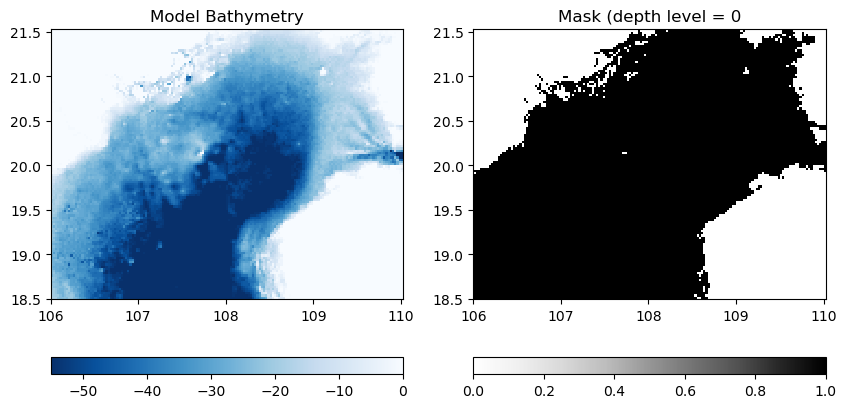

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-55, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

The mask looks appropriate for the bathymetry data.

### Preparing the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. Tile 6 contains the information I need for my interpolation of Ha Long Bay.

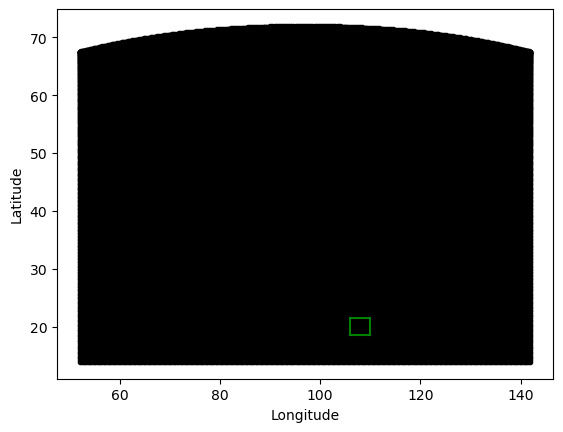

In [11]:
# plot the ECCO tile points from tile 6
plt.plot(ecco_XC_tiles[6],ecco_YC_tiles[6],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, my model boundary (green) is completely surrounded by the points in tile 6 (black). There is a lot of unnecessary information from points outside the longitudes 106-110 and latitude ~18.5-21.5, so I will only read in the information in the immediate area for my use.

In [12]:
# Defines Ha Long Bay domain bounds
lon_min, lon_max = 106.0, 110.0
lat_min, lat_max = 18.5, 21.5

tile_list = [6]  

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_mask_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

# Filter for Ha Long Bay domain
local_indices = (ecco_XC_points >= lon_min) & (ecco_XC_points <= lon_max) & \
            (ecco_YC_points >= lat_min) & (ecco_YC_points <= lat_max)

ecco_XC_points = ecco_XC_points[local_indices ]
ecco_YC_points = ecco_YC_points[local_indices ]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices ]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices ]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices ]
ecco_mask_points = ecco_mask_points[:, local_indices ]

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [13]:
# once tested with the above dict, run and comment with this one
file_prefix_dict = {'ETAN':'ETAN_2004.nc',
                    'THETA':'THETA_2004.nc',
                    'SALT':'SALT_2004.nc',
                    'UVEL':'UVELMASS_2004.nc',
                    'VVEL':'VVELMASS_2004.nc',
                    'MXLDEPTH':'MXLDEPTH_2004.nc'}

variable_names = list(file_prefix_dict.keys())

Now, read the initial condition fields from the same tiles:

In [14]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name == 'ETAN' or variable_name == 'MXLDEPTH':
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:]
        ds.close()
    elif 'VEL' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_2004.nc'))
        u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_2004.nc'))
        v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()
    else:
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:,:]
        ds.close()
    
    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN' or variable_name == 'MXLDEPTH':
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((np.size(ecco_RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name == 'ETAN' or variable_name == 'MXLDEPTH':
            init_grid[0,points_counted:points_counted+N] = \
                 grid[0, tile_number-1, :, :].ravel()
        elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
            if variable_name == 'UVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             u_grid[0, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[0, k, tile_number-1, :, :].ravel()
            if variable_name == 'VVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[0, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             -1*u_grid[0, k, tile_number-1, :, :].ravel()
        else:
            for k in range(np.size(ecco_RF_tiles[1])):
                init_grid[k,points_counted:points_counted+N] = \
                     grid[0, k, tile_number-1, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]

    
    # apply some corrections
    if variable_name == 'UVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
    init_grids.append(init_grid)

### Interpolating the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [15]:
from eccoseas.downscale import horizontal

In [16]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    # print a message to keep track of which variable we are working on
    # uncomment to use
    # print('    - Interpolating the '+variable_name+' grid')

    if variable_name == 'ETAN' or variable_name == 'MXLDEPTH':
        model_mask = mask[:1,:,:]
    else:
        n_levels = min(init_grid.shape[0], mask.shape[0])  # Take smaller of two
        model_mask = mask[:n_levels,:,:]
        init_grid = init_grid[:n_levels,:]

    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_mask_points, 
                                                       XC, YC, model_mask)


    # output the interpolated grid
    output_file = os.path.join(input_path,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

### Plotting the External Forcing Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [17]:
meta_dict = {'ETAN':[0.1, 1, 'viridis', 'm'],
            'THETA':[6, 28, 'turbo', 'C'],
            'SALT':[32, 35, 'viridis', 'ppt'],
            'UVEL':[-0.05, 0.05, 'seismic', 'm/s'],
            'VVEL':[-0.05, 0.05, 'seismic', 'm/s'],
            'MXLDEPTH':[0,50,'viridis','m']}

Then, I'll create all of the subplots. First, I will create custom color maps to better illustrate the slight variation in data, as some variables in my region are uniform over the domain.

In [18]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgba

def create_custom_colormap(data, land_color='lightgray', ocean_cmap_name='viridis'):

    valid_data = data[np.isfinite(data) & (data != 0)]

    if valid_data.size == 0:
        return ListedColormap([land_color, plt.cm.viridis(0.5)])

    min_val = np.min(valid_data)
    max_val = np.max(valid_data)

    if min_val == max_val:
        return ListedColormap([land_color, plt.cm.viridis(0.5)])

    ocean_cmap = plt.cm.get_cmap(ocean_cmap_name)
    num_colors = 256
    color_list = ocean_cmap(np.linspace(0, 1, num_colors))

    # Convert land_color to RGBA
    land_rgba = to_rgba(land_color)
    land_colors_rgba = np.tile(land_rgba, (num_colors, 1)) 

    custom_colors = np.vstack([land_colors_rgba, color_list])
    custom_cmap = LinearSegmentedColormap.from_list(
        'custom_cmap', custom_colors
    )
    custom_cmap.set_under(land_color)
    custom_cmap.set_over(ocean_cmap(1.0))
    custom_cmap.set_bad(land_color)

    return custom_cmap, min_val, max_val

def create_velocity_colormap(data, land_color='lightgray', velocity_cmap_name='seismic'):

    masked_data = np.ma.masked_where(np.isnan(data), data) 
    valid_data = masked_data[~masked_data.mask]

    if valid_data.size == 0:
        return ListedColormap([land_color, plt.cm.seismic(0.5)]), -1, 1 # Default if no valid data

    min_val = np.min(valid_data)
    max_val = np.max(valid_data)

    if min_val == max_val:
        return ListedColormap([land_color, plt.cm.seismic(0.5)]), min_val, max_val # Default if no range

    velocity_cmap = plt.cm.get_cmap(velocity_cmap_name)
    num_colors = 256
    color_list = velocity_cmap(np.linspace(0, 1, num_colors))

    custom_colors = color_list # Directly use the velocity colormap

    custom_cmap = LinearSegmentedColormap.from_list(
        'custom_vel_cmap', custom_colors
    )
    custom_cmap.set_bad(land_color) # Color for NaN or masked land values

    return custom_cmap, min_val, max_val

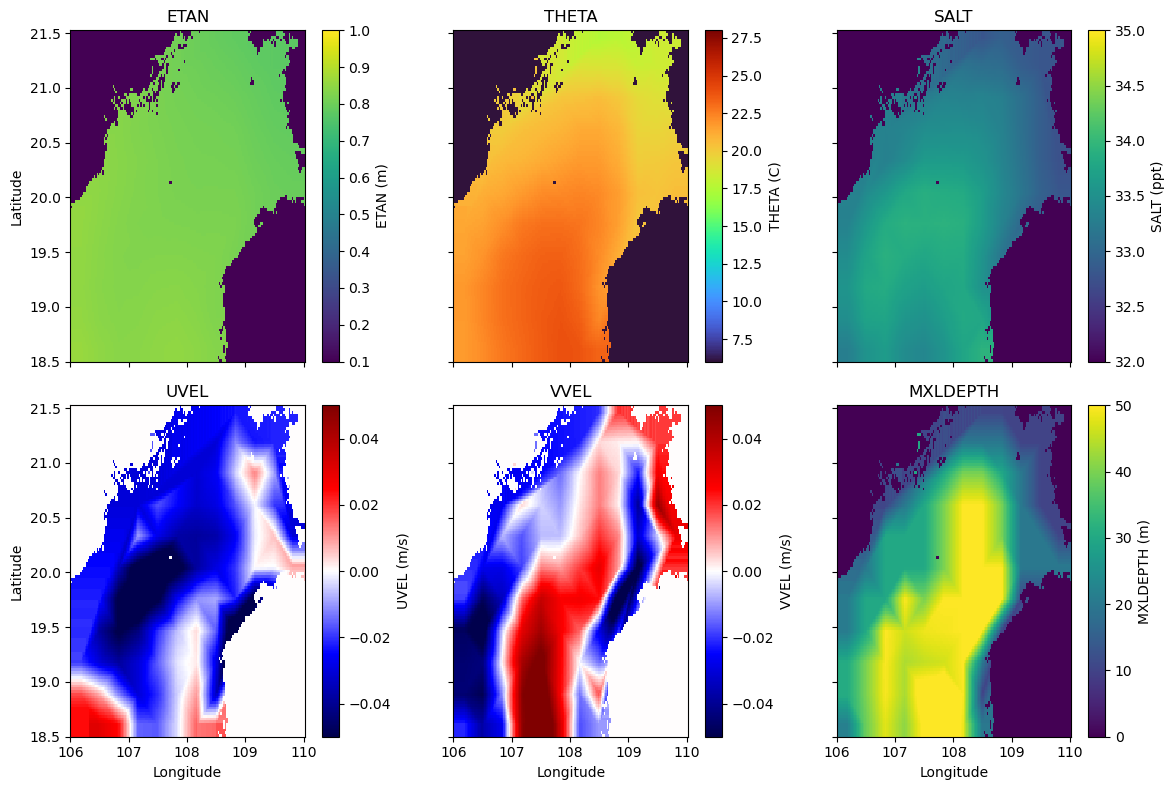

In [19]:
fig = plt.figure(figsize=(12,8))

for i in range(len(variable_names)):
    variable_name = variable_names[i]

    HLB_init_grid = np.fromfile(os.path.join(input_path,variable_name+'_IC.bin'),'>f4')

    if variable_name == 'ETAN' or variable_name == 'MXLDEPTH':
        HLB_init_grid = HLB_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        HLB_init_grid = HLB_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        HLB_init_grid = HLB_init_grid[0, :, :] # choose just the surface for plotting

    plt.subplot(2,3,i+1)

    
    C = plt.pcolormesh(XC, YC, HLB_init_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
        
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

    if i >= 3:
        plt.gca().set_xlabel('Longitude')
    else:
        plt.gca().set_xticklabels([])

    if i % 3 == 0:  
        plt.gca().set_ylabel('Latitude')
    else:
        plt.gca().set_yticklabels([])

    plt.title(variable_name)

plt.tight_layout()
plt.show()

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```
Add for MXL Depth Initialization
```
useMXLDEPTH = .TRUE.,
mxldepthFile = 'MXLDEPTH_IC.bin',
```